# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_Per_Band/224_band3.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546  0.254761  0.411689 -0.341129 -0.677476  0.153730 -0.035699   
      201547  0.602044  0.550390 -0.094586  0.030182  0.091461  0.092833   
      201548  0.162565  0.264788 -0.124271  0.156346  0.590569 -0.025040   
      201549 -0.220484  0.066524 -0.036095 -0.057723  0.031295 -0.037265   
      201550  0.253167 -0.065073 -0.363430 -0.803828  0.042226  0.141678   

                     6         7         8         9  ...      1015      1016  \
41001 201546 -0.516795 -0.397965  0.230384  0.466306  ...  0.823942 -0.298990   
      201547  0.182740  0.269718 -0.440392  0.304993  ...  0.170062  0.014354   
      201548 -0.112801  0.234076 -0.500682 -0.027234  ...  0.277929 -0.462339   
      201549 -0.270820  0.395030  0.009534 -0.186166  ...  0.020547  0.114108   
      201550  0.212588  0.185511  0.231764  0.084272  ... -0.166497 -0.402745   

                  1017      1018      1019      1020      1021      1022  \
41001 201546 -0.037435  0.043740 -0.747845 -0.051514  0.004457 -0.123293   
      201547 -0.076718 -0.200389 -0.317777  0.237759 -0.883714  0.237042   
      201548 -0.275402 -0.546082 -0.244477 -0.478742  0.130856  0.259331   
      201549 -0.364141 -0.070821  0.173767  0.283687 -0.016172 -0.292805   
      201550  0.352260 -0.232156  0.098754 -0.455867  0.175542  0.051047   

                  1023    Labels  
41001 201546  0.612457 -0.861740  
      201547 -0.108539 -0.854589  
      201548  0.298724 -0.856973  
      201549  0.302524 -0.856973  
      201550  0.464865 -0.823600  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820 -0.038914  0.322808  0.373199 -0.283502 -0.271566  0.088626   
      201821  0.119647  0.132793  0.021242 -0.698521 -0.381515 -0.165313   
      201822 -0.469784 -0.143350 -0.189662  0.023369  0.435589 -0.714174   
      201823  0.257122  0.042989 -0.301947 -0.504741  0.117907 -0.400737   
      201824  0.019805 -0.337798 -0.293866  0.330593 -0.024377 -0.798601   

                     6         7         8         9  ...      1015      1016  \
41001 201820 -0.026355  0.218662  0.409598  0.561794  ...  0.143423  0.395533   
      201821 -0.752299  0.143025 -0.168514  0.194527  ... -0.030163 -0.127638   
      201822 -0.283725 -0.475974 -0.156302  0.130883  ... -0.097055 -0.000823   
      201823  0.110022  0.167397 -0.348951 -0.003689  ... -0.132598 -0.087470   
      201824  0.293243 -0.122561 -0.436969  0.286335  ...  0.027044 -0.097869   

                  1017      1018      1019      1020      1021      1022  \
41001 201820 -0.030158 -0.111589 -0.372532 -0.072803  0.179085  0.194626   
      201821  0.221971 -0.480831 -0.141544 -0.325766 -0.067915 -0.405215   
      201822  0.040563  0.032051  0.222446  0.467475  0.550198 -0.418891   
      201823 -0.267376 -0.110186 -0.174371  0.129426 -0.167188  0.180180   
      201824  0.332868  0.441772  0.018846  0.094240 -0.158402 -0.062242   

                  1023    Labels  
41001 201820 -0.005898 -0.949940  
      201821 -0.262246 -0.961859  
      201822  0.482766 -0.940405  
      201823 -0.319141 -0.961859  
      201824  0.393861 -0.954708  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 1025)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 1024)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 1024)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

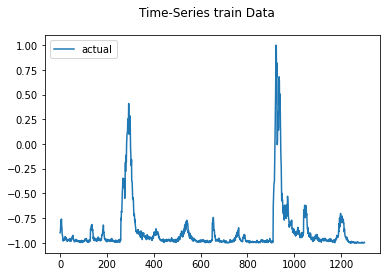

2023-03-14 14:15:49.789214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 14:15:49.789283: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 14:15:49.789333: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-14 14:15:49.789650: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 14:15:49.900821: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 38.821
Test RMSE: 47.681
Test sMAPE: 103.234
Test R Squared: -1.352
{'mae': 38.82075207630793, 'rmse': 47.680671882358524, 'smape': 103.23393843266592, 'r2': -1.3524843056370113}


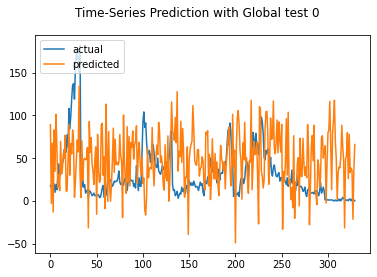

Test MAE: 34.939
Test RMSE: 43.239
Test sMAPE: 93.419
Test R Squared: -0.935
{'mae': 34.93938965002696, 'rmse': 43.23873536474393, 'smape': 93.41866397378745, 'r2': -0.9345856781167778}


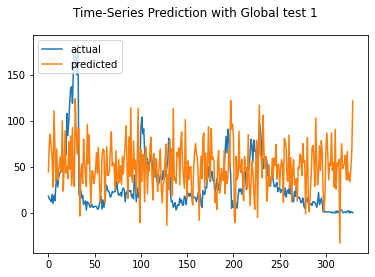

Test MAE: 37.659
Test RMSE: 48.111
Test sMAPE: 103.671
Test R Squared: -1.395
{'mae': 37.65921891313611, 'rmse': 48.110963162351815, 'smape': 103.67065359003578, 'r2': -1.395135591889027}


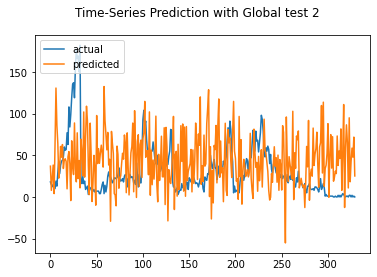

Test MAE: 45.537
Test RMSE: 56.551
Test sMAPE: 110.739
Test R Squared: -2.309
{'mae': 45.537103564811474, 'rmse': 56.55144179480904, 'smape': 110.73874892063988, 'r2': -2.309248383500845}


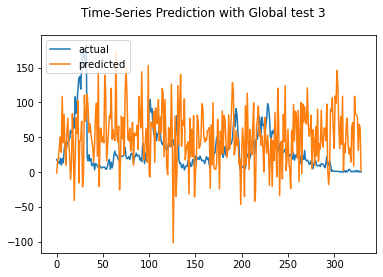

Test MAE: 56.018
Test RMSE: 64.175
Test sMAPE: 107.381
Test R Squared: -3.262
{'mae': 56.01830238717975, 'rmse': 64.17494543892082, 'smape': 107.3810056968636, 'r2': -3.261603278485656}


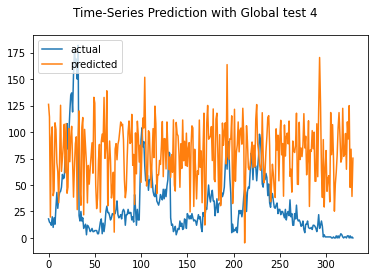

Test MAE: 49.819
Test RMSE: 60.524
Test sMAPE: 106.508
Test R Squared: -2.790
{'mae': 49.81907502575354, 'rmse': 60.52368671608244, 'smape': 106.50758797847455, 'r2': -2.790467269366222}


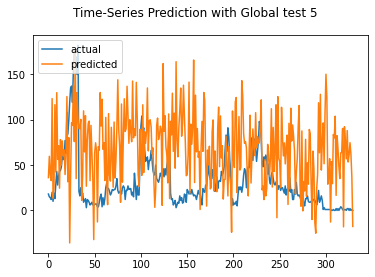

Test MAE: 64.063
Test RMSE: 72.547
Test sMAPE: 112.476
Test R Squared: -4.446
{'mae': 64.06323841268366, 'rmse': 72.54702829386716, 'smape': 112.47585887868188, 'r2': -4.446045386760852}


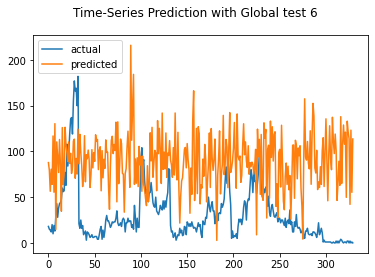

Test MAE: 45.168
Test RMSE: 54.262
Test sMAPE: 102.807
Test R Squared: -2.047
{'mae': 45.16820535641728, 'rmse': 54.261611496007966, 'smape': 102.80656962564218, 'r2': -2.0466837543195098}


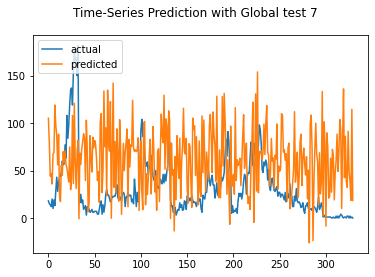

Test MAE: 45.405
Test RMSE: 55.600
Test sMAPE: 103.067
Test R Squared: -2.199
{'mae': 45.405351068576174, 'rmse': 55.599991587923135, 'smape': 103.06747257324417, 'r2': -2.198832158479505}


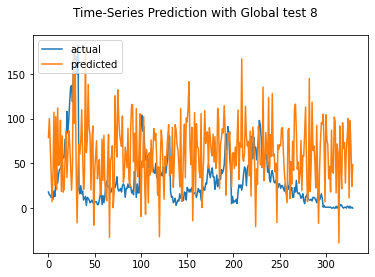

Test MAE: 33.441
Test RMSE: 42.692
Test sMAPE: 98.181
Test R Squared: -0.886
{'mae': 33.44052279257413, 'rmse': 42.69192478157153, 'smape': 98.18110833369366, 'r2': -0.8859643227189353}


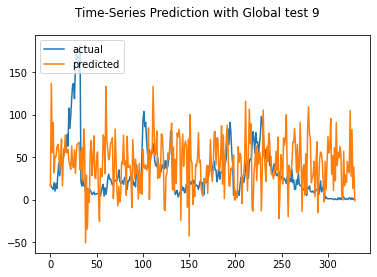

Test MAE: 42.519
Test RMSE: 51.796
Test sMAPE: 102.426
Test R Squared: -1.776
{'mae': 42.51858074701194, 'rmse': 51.796496650217904, 'smape': 102.42607616933475, 'r2': -1.776149018683507}


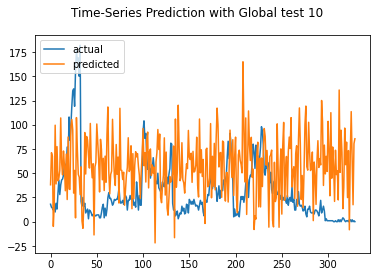

Test MAE: 60.454
Test RMSE: 68.764
Test sMAPE: 111.485
Test R Squared: -3.893
{'mae': 60.453620951825926, 'rmse': 68.76361745088487, 'smape': 111.48499666892806, 'r2': -3.892822183705519}


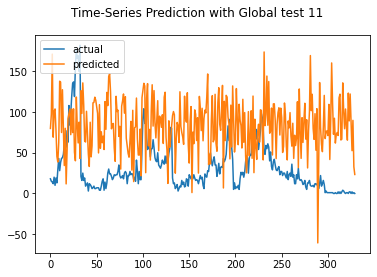

Test MAE: 39.917
Test RMSE: 49.479
Test sMAPE: 100.189
Test R Squared: -1.533
{'mae': 39.917490699435724, 'rmse': 49.479254342376954, 'smape': 100.18876330205458, 'r2': -1.5333097461804788}


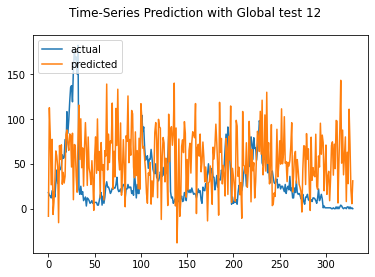

Test MAE: 46.448
Test RMSE: 55.351
Test sMAPE: 102.752
Test R Squared: -2.170
{'mae': 46.447864799969125, 'rmse': 55.35052843598603, 'smape': 102.7523521834442, 'r2': -2.1701918461945775}


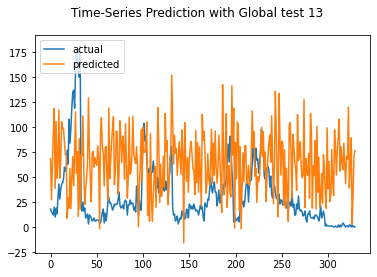

Test MAE: 49.958
Test RMSE: 60.265
Test sMAPE: 104.348
Test R Squared: -2.758
{'mae': 49.958351242903504, 'rmse': 60.264703057209275, 'smape': 104.3481998354791, 'r2': -2.758097503686943}


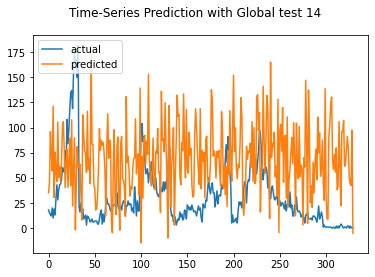

Test MAE: 44.125
Test RMSE: 54.098
Test sMAPE: 100.182
Test R Squared: -2.028
{'mae': 44.12499929052411, 'rmse': 54.0984203009279, 'smape': 100.18243314123269, 'r2': -2.028385576305521}


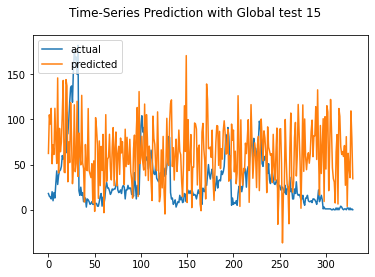

Test MAE: 50.932
Test RMSE: 59.446
Test sMAPE: 107.003
Test R Squared: -2.657
{'mae': 50.93176026091431, 'rmse': 59.44574411787858, 'smape': 107.0032900893857, 'r2': -2.656651210527207}


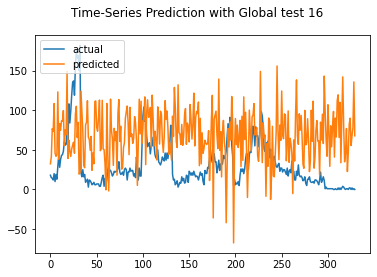

Test MAE: 43.848
Test RMSE: 53.951
Test sMAPE: 97.394
Test R Squared: -2.012
{'mae': 43.84787788011811, 'rmse': 53.950853989780036, 'smape': 97.39444196492586, 'r2': -2.011886824973959}


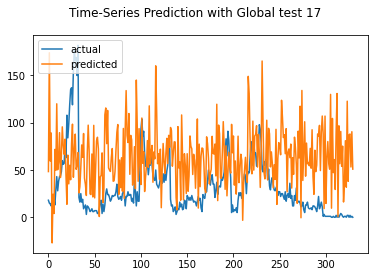

Test MAE: 44.482
Test RMSE: 53.017
Test sMAPE: 98.940
Test R Squared: -1.909
{'mae': 44.482240079388475, 'rmse': 53.017132709113646, 'smape': 98.94037830543277, 'r2': -1.9085362063574793}


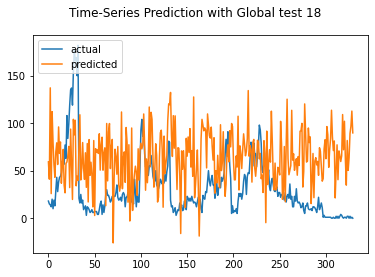

Test MAE: 46.645
Test RMSE: 56.152
Test sMAPE: 103.963
Test R Squared: -2.263
{'mae': 46.64538752201832, 'rmse': 56.152406614884356, 'smape': 103.96280659233378, 'r2': -2.262712074627642}


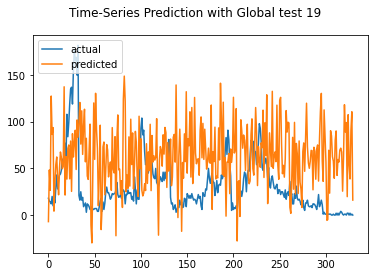

Test MAE: 39.353
Test RMSE: 48.758
Test sMAPE: 106.209
Test R Squared: -1.460
{'mae': 39.352933045589566, 'rmse': 48.757520815309626, 'smape': 106.2089507549049, 'r2': -1.4599440607632985}


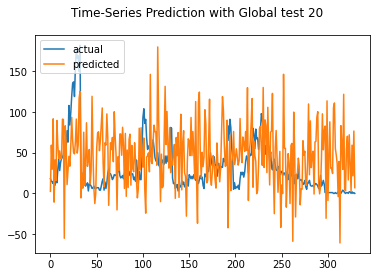

Test MAE: 59.082
Test RMSE: 67.733
Test sMAPE: 109.509
Test R Squared: -3.747
{'mae': 59.08236324082721, 'rmse': 67.73287878778622, 'smape': 109.50933421031282, 'r2': -3.747238711921961}


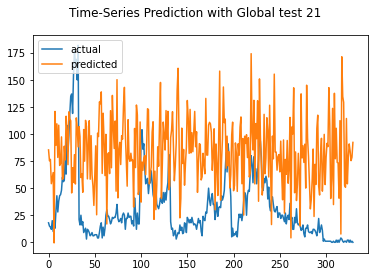

Test MAE: 42.471
Test RMSE: 52.870
Test sMAPE: 101.720
Test R Squared: -1.892
{'mae': 42.47052390575409, 'rmse': 52.869629189927906, 'smape': 101.7197221583412, 'r2': -1.8923745431944754}


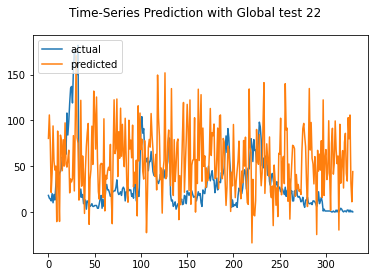

Test MAE: 40.591
Test RMSE: 49.612
Test sMAPE: 98.090
Test R Squared: -1.547
{'mae': 40.5911935928193, 'rmse': 49.612365533906804, 'smape': 98.09041036305285, 'r2': -1.5469585157173462}


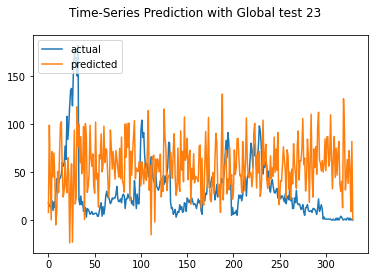

Test MAE: 46.154
Test RMSE: 54.558
Test sMAPE: 104.306
Test R Squared: -2.080
{'mae': 46.15449069377148, 'rmse': 54.557726486541505, 'smape': 104.30555360280339, 'r2': -2.0800270462513124}


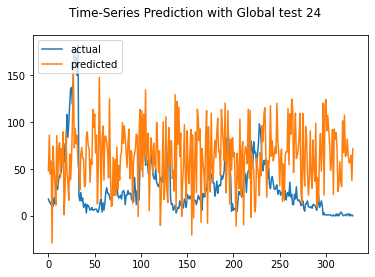

Test MAE: 37.075
Test RMSE: 45.492
Test sMAPE: 102.669
Test R Squared: -1.142
{'mae': 37.07469943743764, 'rmse': 45.492378026409654, 'smape': 102.66856968691567, 'r2': -1.1415059250443886}


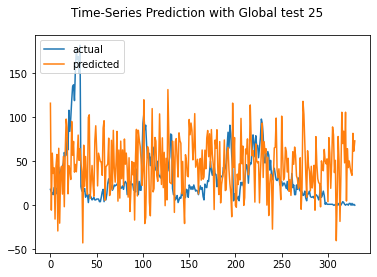

Test MAE: 53.621
Test RMSE: 62.423
Test sMAPE: 105.586
Test R Squared: -3.032
{'mae': 53.621005192669955, 'rmse': 62.42320828514886, 'smape': 105.58580086866176, 'r2': -3.0321267268587295}


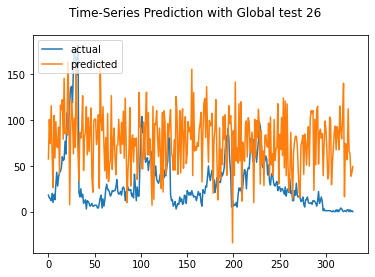

Test MAE: 53.631
Test RMSE: 62.821
Test sMAPE: 110.300
Test R Squared: -3.084
{'mae': 53.63083140633323, 'rmse': 62.820890244537814, 'smape': 110.2999260942632, 'r2': -3.0836656289512385}


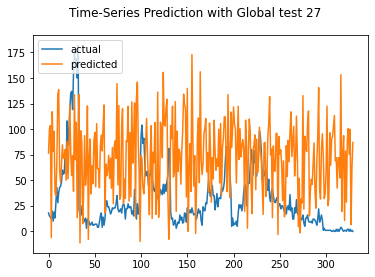

Test MAE: 43.934
Test RMSE: 54.347
Test sMAPE: 103.456
Test R Squared: -2.056
{'mae': 43.933824073545864, 'rmse': 54.34729068933442, 'smape': 103.45621128741358, 'r2': -2.056312789966714}


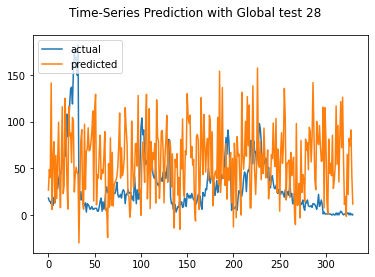

Test MAE: 39.872
Test RMSE: 48.063
Test sMAPE: 97.997
Test R Squared: -1.390
{'mae': 39.872202376885845, 'rmse': 48.063231480079025, 'smape': 97.99679931833975, 'r2': -1.390385442140623}


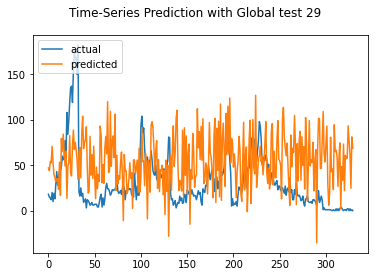

Test MAE: 46.838
Test RMSE: 55.270
Test sMAPE: 105.425
Test R Squared: -2.161
{'mae': 46.83775652069034, 'rmse': 55.26997535059012, 'smape': 105.42514537363895, 'r2': -2.1609712327952937}


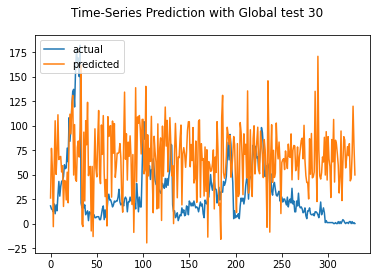

Test MAE: 54.333
Test RMSE: 62.053
Test sMAPE: 107.046
Test R Squared: -2.984
{'mae': 54.33268744295294, 'rmse': 62.0528878866305, 'smape': 107.04637684866648, 'r2': -2.9844281308101017}


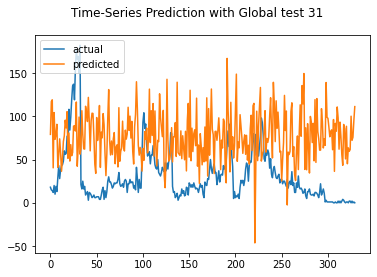

Test MAE: 52.025
Test RMSE: 60.910
Test sMAPE: 106.476
Test R Squared: -2.839
{'mae': 52.02465785922426, 'rmse': 60.909530508554646, 'smape': 106.4763774414126, 'r2': -2.838950440792876}


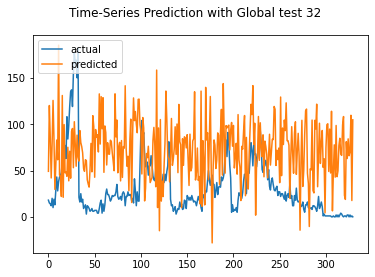

Test MAE: 43.613
Test RMSE: 52.297
Test sMAPE: 101.408
Test R Squared: -1.830
{'mae': 43.61336190718593, 'rmse': 52.29659774894219, 'smape': 101.40775761210934, 'r2': -1.8300158872433356}


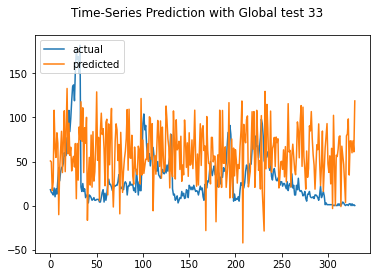

Test MAE: 44.328
Test RMSE: 54.192
Test sMAPE: 99.161
Test R Squared: -2.039
{'mae': 44.32828922795527, 'rmse': 54.19184768062871, 'smape': 99.16078510109867, 'r2': -2.038854585922244}


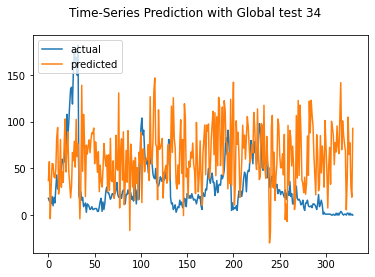

Test MAE: 42.456
Test RMSE: 50.433
Test sMAPE: 99.216
Test R Squared: -1.632
{'mae': 42.455782906575635, 'rmse': 50.432911784641824, 'smape': 99.2164589112375, 'r2': -1.6319042665642938}


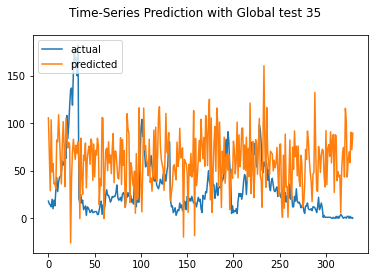

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 44.101
Test RMSE: 55.425
Test sMAPE: 109.902
Test R Squared: -2.179
{'mae': 44.100712364460485, 'rmse': 55.425488396375016, 'smape': 109.90244635618456, 'r2': -2.1787842978091514}


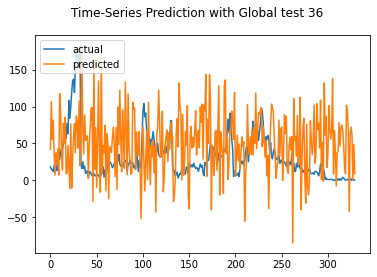

Test MAE: 47.262
Test RMSE: 55.939
Test sMAPE: 102.657
Test R Squared: -2.238
{'mae': 47.26186250068925, 'rmse': 55.93897934467831, 'smape': 102.65731155796975, 'r2': -2.2379570051029836}


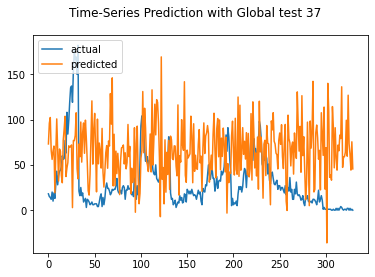

Test MAE: 38.864
Test RMSE: 48.725
Test sMAPE: 109.857
Test R Squared: -1.457
{'mae': 38.863996389056695, 'rmse': 48.724673195490894, 'smape': 109.85652999544287, 'r2': -1.4566306810998002}


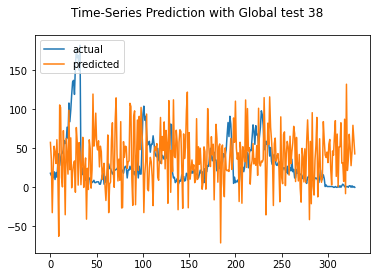

Test MAE: 52.082
Test RMSE: 60.559
Test sMAPE: 104.962
Test R Squared: -2.795
{'mae': 52.0815984733177, 'rmse': 60.55949025600918, 'smape': 104.96233092292422, 'r2': -2.7949531919756914}


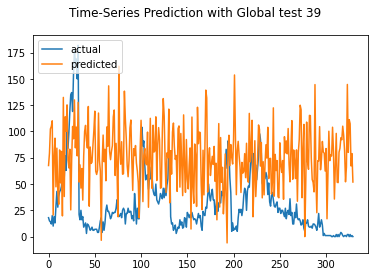

Test MAE: 35.538
Test RMSE: 44.545
Test sMAPE: 94.094
Test R Squared: -1.053
{'mae': 35.537758352900994, 'rmse': 44.544920289721254, 'smape': 94.09384040264531, 'r2': -1.053233653398593}


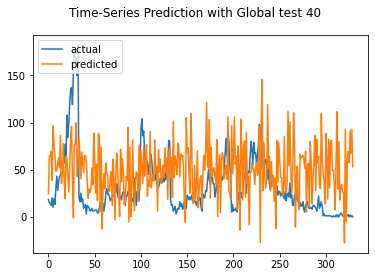

Test MAE: 47.403
Test RMSE: 55.852
Test sMAPE: 100.562
Test R Squared: -2.228
{'mae': 47.40310028032823, 'rmse': 55.85235094539065, 'smape': 100.56182567820647, 'r2': -2.2279360200243103}


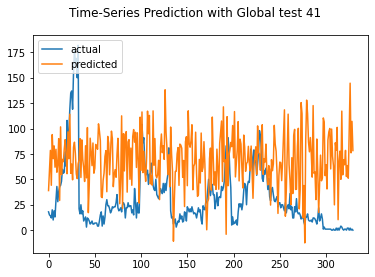

Test MAE: 46.989
Test RMSE: 55.179
Test sMAPE: 103.585
Test R Squared: -2.151
{'mae': 46.98850044698426, 'rmse': 55.17933649769715, 'smape': 103.58498097985161, 'r2': -2.150612195024908}


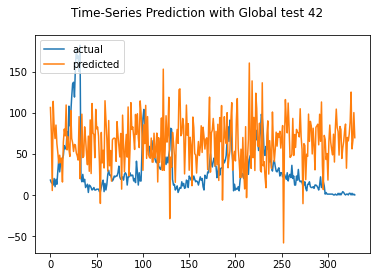

Test MAE: 49.077
Test RMSE: 57.349
Test sMAPE: 101.872
Test R Squared: -2.403
{'mae': 49.077293919072005, 'rmse': 57.349302331739764, 'smape': 101.87236263479096, 'r2': -2.4032846867803914}


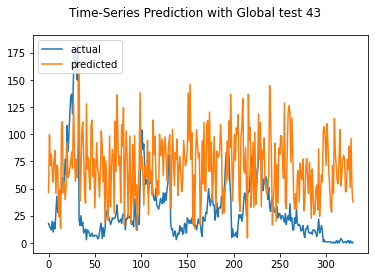

Test MAE: 38.259
Test RMSE: 48.248
Test sMAPE: 112.659
Test R Squared: -1.409
{'mae': 38.259044443025736, 'rmse': 48.24770804628153, 'smape': 112.65930751198586, 'r2': -1.408770238652238}


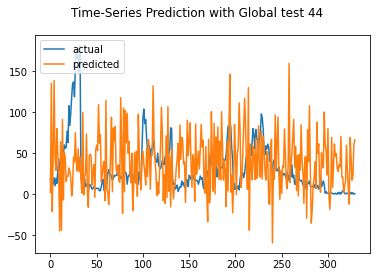

Test MAE: 45.564
Test RMSE: 54.434
Test sMAPE: 99.325
Test R Squared: -2.066
{'mae': 45.563870989915095, 'rmse': 54.433723339970506, 'smape': 99.32514596936323, 'r2': -2.066041895992937}


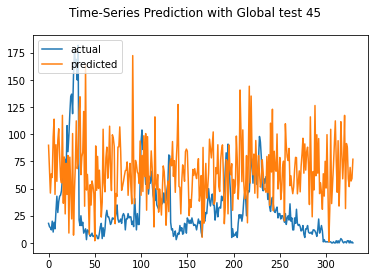

Test MAE: 40.306
Test RMSE: 48.733
Test sMAPE: 99.359
Test R Squared: -1.457
{'mae': 40.30599351651741, 'rmse': 48.73311592607276, 'smape': 99.35916442720283, 'r2': -1.4574820964723942}


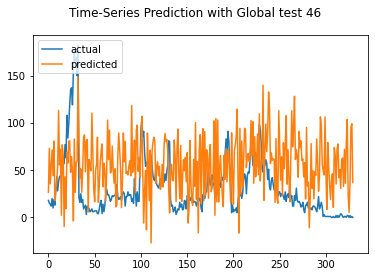

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 41.344
Test RMSE: 53.563
Test sMAPE: 121.521
Test R Squared: -1.969
{'mae': 41.34380573702581, 'rmse': 53.563360503994865, 'smape': 121.52113409856624, 'r2': -1.9687773936561581}


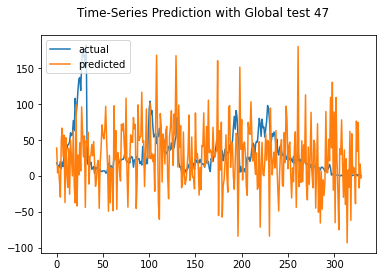

Test MAE: 35.770
Test RMSE: 45.268
Test sMAPE: 104.227
Test R Squared: -1.120
{'mae': 35.76993730835842, 'rmse': 45.26764371267898, 'smape': 104.2267221849094, 'r2': -1.1203999227522936}


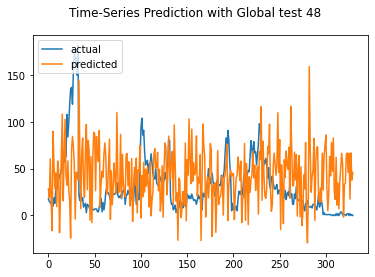

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 40.276
Test RMSE: 49.784
Test sMAPE: 105.837
Test R Squared: -1.565
{'mae': 40.27550494273503, 'rmse': 49.78376221018436, 'smape': 105.83732161196892, 'r2': -1.5645869549559825}


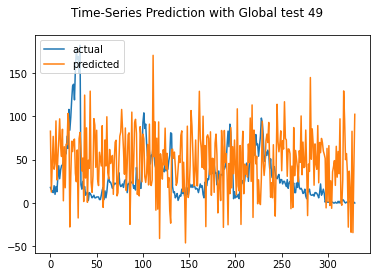

Test MAE: 40.250
Test RMSE: 48.590
Test sMAPE: 98.074
Test R Squared: -1.443
{'mae': 40.24970578316486, 'rmse': 48.59001036800785, 'smape': 98.07371181300735, 'r2': -1.4430704183261303}


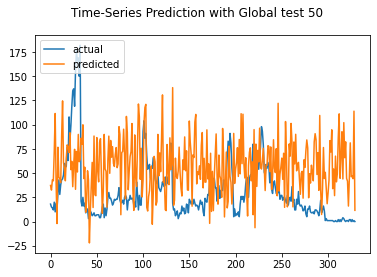

Test MAE: 49.101
Test RMSE: 58.623
Test sMAPE: 105.611
Test R Squared: -2.556
{'mae': 49.100999502882814, 'rmse': 58.62340165142342, 'smape': 105.61105816835455, 'r2': -2.556182427672043}


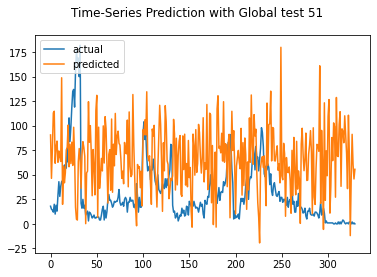

Test MAE: 63.503
Test RMSE: 71.651
Test sMAPE: 112.957
Test R Squared: -4.312
{'mae': 63.502988409996036, 'rmse': 71.6512757802395, 'smape': 112.95720341222821, 'r2': -4.312388854267695}


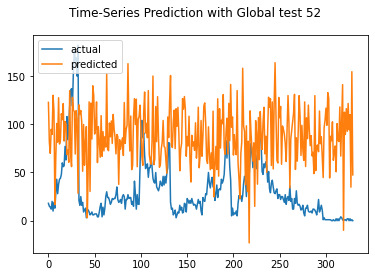

Test MAE: 39.480
Test RMSE: 48.813
Test sMAPE: 100.271
Test R Squared: -1.466
{'mae': 39.479561710899524, 'rmse': 48.812590611047206, 'smape': 100.27052573495405, 'r2': -1.4655040284586627}


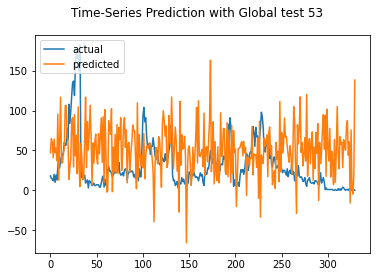

Test MAE: 53.684
Test RMSE: 63.270
Test sMAPE: 107.295
Test R Squared: -3.142
{'mae': 53.68376841328361, 'rmse': 63.27018672863647, 'smape': 107.29493900908132, 'r2': -3.1422874595200057}


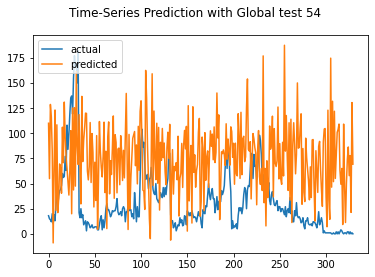

Test MAE: 50.057
Test RMSE: 58.512
Test sMAPE: 107.560
Test R Squared: -2.543
{'mae': 50.057313134995375, 'rmse': 58.512038217551506, 'smape': 107.56038532412585, 'r2': -2.5426843187512365}


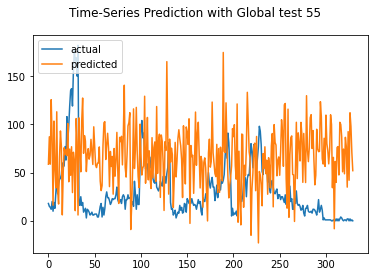

Test MAE: 43.164
Test RMSE: 52.631
Test sMAPE: 100.798
Test R Squared: -1.866
{'mae': 43.16431510340084, 'rmse': 52.63146588187507, 'smape': 100.79769740912177, 'r2': -1.8663745147472706}


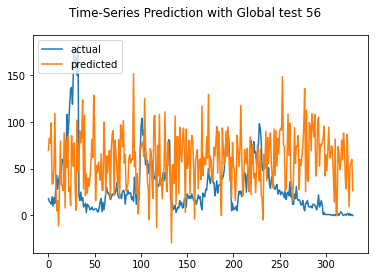

Test MAE: 35.478
Test RMSE: 45.512
Test sMAPE: 97.396
Test R Squared: -1.143
{'mae': 35.47841273799087, 'rmse': 45.51182421411286, 'smape': 97.39590116544609, 'r2': -1.143337134077607}


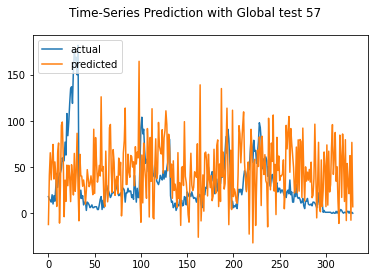

Test MAE: 37.591
Test RMSE: 47.423
Test sMAPE: 97.641
Test R Squared: -1.327
{'mae': 37.590913809610136, 'rmse': 47.4232368225881, 'smape': 97.64086223172298, 'r2': -1.327150055116102}


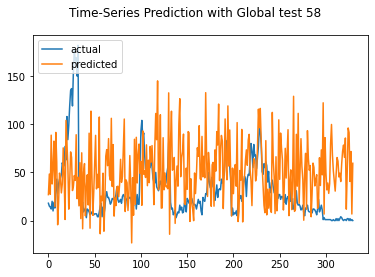

Test MAE: 39.496
Test RMSE: 48.515
Test sMAPE: 100.251
Test R Squared: -1.436
{'mae': 39.495935813224676, 'rmse': 48.51484640009129, 'smape': 100.25052950065707, 'r2': -1.4355178849677408}


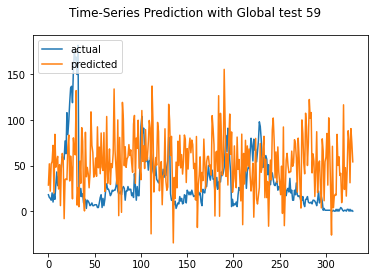

Test MAE: 55.544
Test RMSE: 64.517
Test sMAPE: 107.448
Test R Squared: -3.307
{'mae': 55.5438261198275, 'rmse': 64.51749128696815, 'smape': 107.4477940655759, 'r2': -3.3072189144012363}


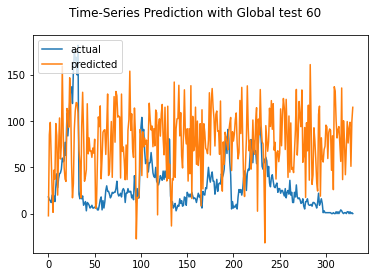

Test MAE: 33.877
Test RMSE: 44.438
Test sMAPE: 96.763
Test R Squared: -1.043
{'mae': 33.87718394398689, 'rmse': 44.437688828676606, 'smape': 96.76263320042791, 'r2': -1.0433601936307269}


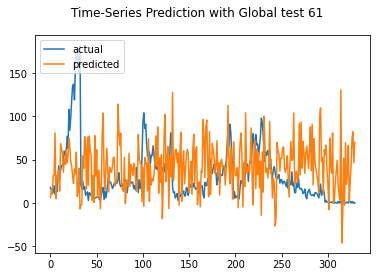

Test MAE: 62.817
Test RMSE: 72.411
Test sMAPE: 113.953
Test R Squared: -4.426
{'mae': 62.81739608446757, 'rmse': 72.41127817773547, 'smape': 113.95287776473472, 'r2': -4.425683157729667}


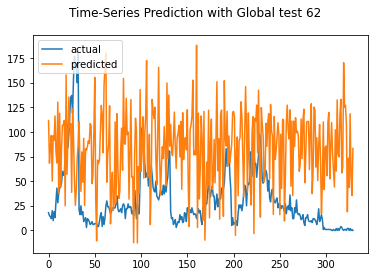

Test MAE: 77.450
Test RMSE: 86.555
Test sMAPE: 120.250
Test R Squared: -6.752
{'mae': 77.45017038981119, 'rmse': 86.55510828270904, 'smape': 120.25000311850758, 'r2': -6.752243574166141}


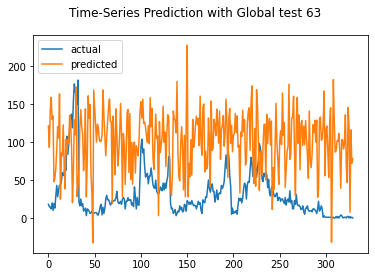

Test MAE: 42.187
Test RMSE: 51.102
Test sMAPE: 101.901
Test R Squared: -1.702
{'mae': 42.18712213617383, 'rmse': 51.10217227406311, 'smape': 101.90116529742559, 'r2': -1.7022201311389362}


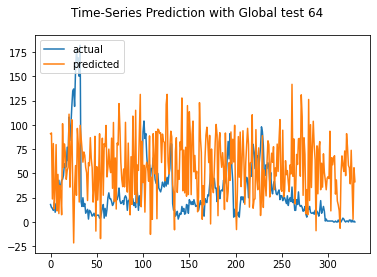

Test MAE: 51.707
Test RMSE: 61.193
Test sMAPE: 105.065
Test R Squared: -2.875
{'mae': 51.70746464946053, 'rmse': 61.19341975072904, 'smape': 105.06508625945426, 'r2': -2.874819261208617}


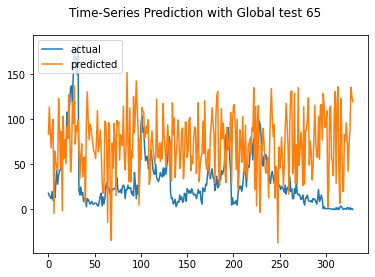

Test MAE: 40.681
Test RMSE: 51.696
Test sMAPE: 100.998
Test R Squared: -1.765
{'mae': 40.68108147021496, 'rmse': 51.695683909620854, 'smape': 100.99831875495667, 'r2': -1.7653529668646253}


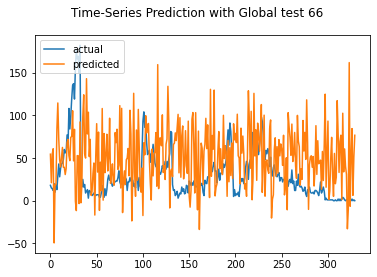

Test MAE: 43.995
Test RMSE: 52.681
Test sMAPE: 97.345
Test R Squared: -1.872
{'mae': 43.9954439163208, 'rmse': 52.68102233511543, 'smape': 97.34524076298317, 'r2': -1.8717748670392376}


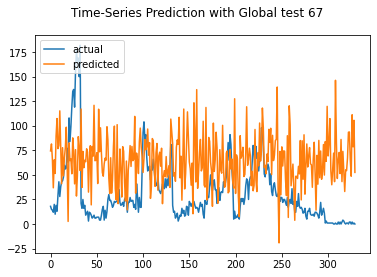

Test MAE: 43.006
Test RMSE: 55.389
Test sMAPE: 107.504
Test R Squared: -2.175
{'mae': 43.00590626452908, 'rmse': 55.38908735007681, 'smape': 107.50363653266933, 'r2': -2.174610294809923}


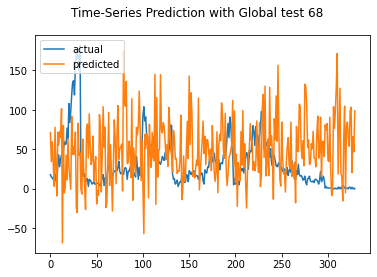

Test MAE: 47.237
Test RMSE: 56.329
Test sMAPE: 101.905
Test R Squared: -2.283
{'mae': 47.236928365447305, 'rmse': 56.328583079352036, 'smape': 101.90549405177879, 'r2': -2.283217511236598}


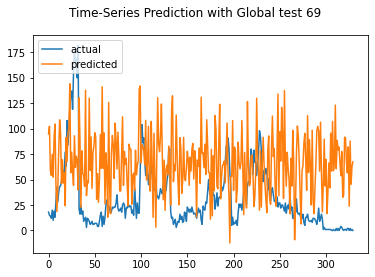

Test MAE: 47.166
Test RMSE: 55.752
Test sMAPE: 103.751
Test R Squared: -2.216
{'mae': 47.1655120002501, 'rmse': 55.752444413968014, 'smape': 103.75118905720791, 'r2': -2.2163983334119552}


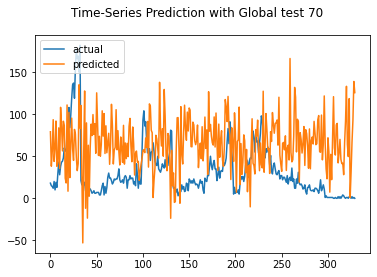

Test MAE: 48.044
Test RMSE: 57.007
Test sMAPE: 101.255
Test R Squared: -2.363
{'mae': 48.044009524764434, 'rmse': 57.00673720673727, 'smape': 101.2550365566115, 'r2': -2.3627483728046683}


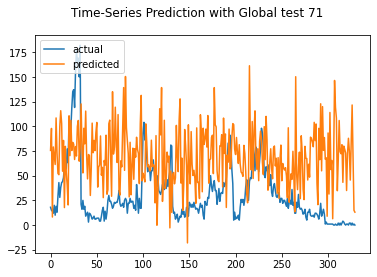

Test MAE: 47.296
Test RMSE: 57.931
Test sMAPE: 102.561
Test R Squared: -2.473
{'mae': 47.296024947997296, 'rmse': 57.93053390306735, 'smape': 102.56123814506881, 'r2': -2.4726184142073375}


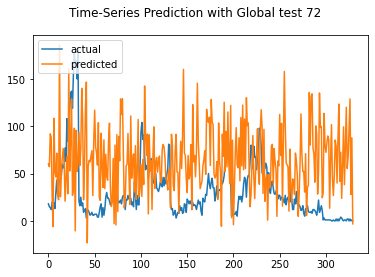

Test MAE: 47.760
Test RMSE: 55.814
Test sMAPE: 102.944
Test R Squared: -2.224
{'mae': 47.76028650746201, 'rmse': 55.814458324821636, 'smape': 102.9442975462527, 'r2': -2.2235575664439975}


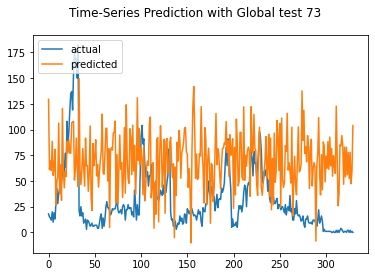

Test MAE: 77.279
Test RMSE: 85.664
Test sMAPE: 119.609
Test R Squared: -6.593
{'mae': 77.27911198355935, 'rmse': 85.66362573288698, 'smape': 119.60909592188233, 'r2': -6.593376008592492}


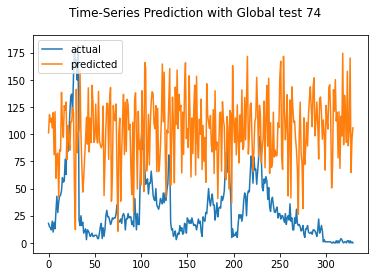

Test MAE: 51.012
Test RMSE: 61.479
Test sMAPE: 110.767
Test R Squared: -2.911
{'mae': 51.011705778584336, 'rmse': 61.47864164706171, 'smape': 110.76672671307743, 'r2': -2.9110244259501377}


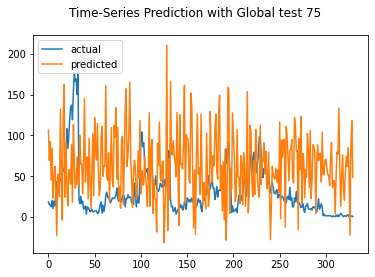

Test MAE: 51.623
Test RMSE: 62.870
Test sMAPE: 108.569
Test R Squared: -3.090
{'mae': 51.622925367319226, 'rmse': 62.869684585930045, 'smape': 108.56946824264354, 'r2': -3.0900118350854973}


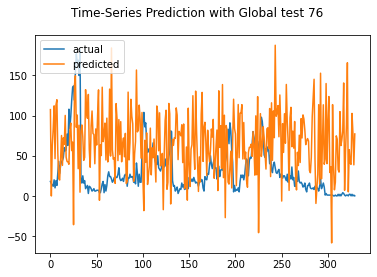

Test MAE: 38.009
Test RMSE: 46.747
Test sMAPE: 96.528
Test R Squared: -1.261
{'mae': 38.008515282291356, 'rmse': 46.74725817828148, 'smape': 96.52773458376895, 'r2': -1.2612797263978326}


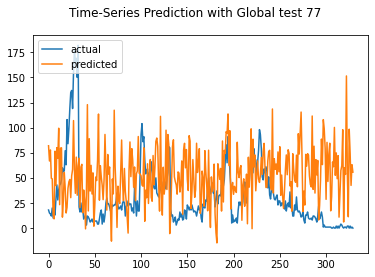

Test MAE: 48.782
Test RMSE: 57.292
Test sMAPE: 103.977
Test R Squared: -2.396
{'mae': 48.78224728757685, 'rmse': 57.29195440883305, 'smape': 103.97714607170818, 'r2': -2.396481684246482}


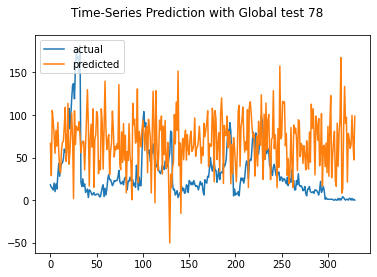

Test MAE: 43.412
Test RMSE: 52.843
Test sMAPE: 101.233
Test R Squared: -1.889
{'mae': 43.411880017410624, 'rmse': 52.84289614654942, 'smape': 101.23310169378429, 'r2': -1.889450277345036}


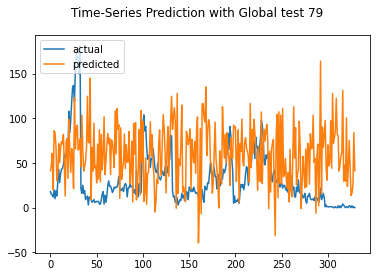

Test MAE: 52.099
Test RMSE: 59.183
Test sMAPE: 106.404
Test R Squared: -2.624
{'mae': 52.098675765413226, 'rmse': 59.18330238349065, 'smape': 106.40387997905677, 'r2': -2.6244356315726183}


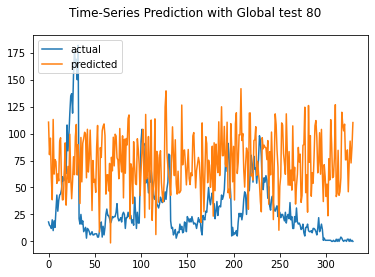

Test MAE: 37.545
Test RMSE: 49.948
Test sMAPE: 119.838
Test R Squared: -1.582
{'mae': 37.54525984263781, 'rmse': 49.94829957367228, 'smape': 119.83783552420688, 'r2': -1.5815670975521332}


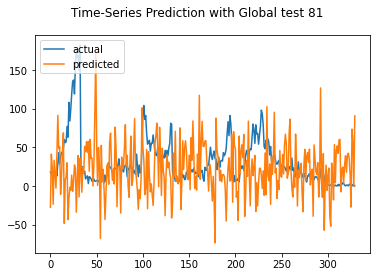

Test MAE: 46.925
Test RMSE: 57.295
Test sMAPE: 102.798
Test R Squared: -2.397
{'mae': 46.92456772471919, 'rmse': 57.294756455297, 'smape': 102.79819804380838, 'r2': -2.3968139239937036}


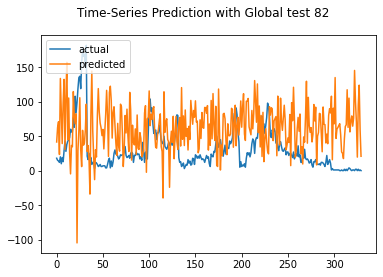

Test MAE: 46.058
Test RMSE: 54.805
Test sMAPE: 107.074
Test R Squared: -2.108
{'mae': 46.05839311480522, 'rmse': 54.80469120865661, 'smape': 107.07371277668615, 'r2': -2.107974678819608}


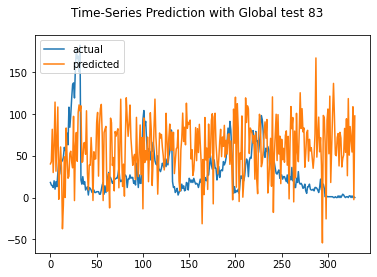

Test MAE: 43.406
Test RMSE: 53.057
Test sMAPE: 99.790
Test R Squared: -1.913
{'mae': 43.40557735761006, 'rmse': 53.056991595849006, 'smape': 99.78977250877617, 'r2': -1.9129111918921655}


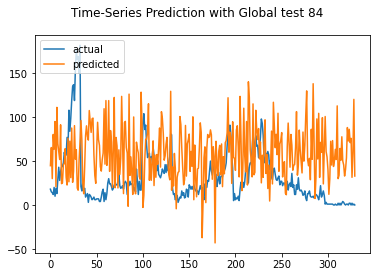

Test MAE: 88.143
Test RMSE: 95.877
Test sMAPE: 126.213
Test R Squared: -8.512
{'mae': 88.14312653397069, 'rmse': 95.87745490751472, 'smape': 126.21341997232861, 'r2': -8.512069083217686}


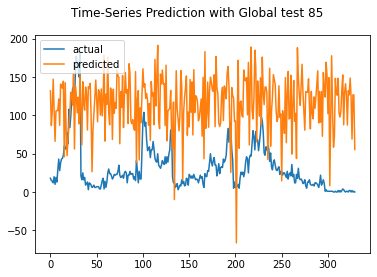

Test MAE: 58.913
Test RMSE: 68.016
Test sMAPE: 109.539
Test R Squared: -3.787
{'mae': 58.912749755743775, 'rmse': 68.01580951858233, 'smape': 109.53947420519302, 'r2': -3.78698144819674}


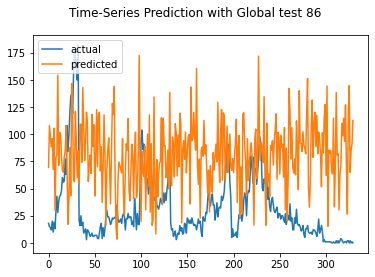

Test MAE: 57.723
Test RMSE: 65.813
Test sMAPE: 109.656
Test R Squared: -3.482
{'mae': 57.7225868918679, 'rmse': 65.81312942313674, 'smape': 109.65603896107751, 'r2': -3.4819508098106056}


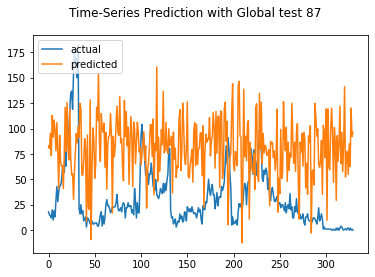

Test MAE: 51.004
Test RMSE: 59.875
Test sMAPE: 104.778
Test R Squared: -2.710
{'mae': 51.003977410721056, 'rmse': 59.87514789068442, 'smape': 104.77811725811837, 'r2': -2.709669333597163}


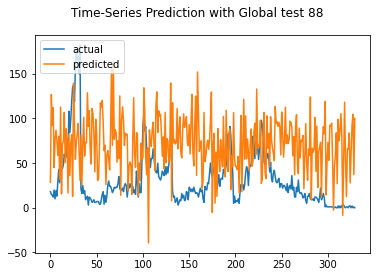

Test MAE: 69.032
Test RMSE: 77.694
Test sMAPE: 115.364
Test R Squared: -5.246
{'mae': 69.03162670713482, 'rmse': 77.69353273818098, 'smape': 115.36358074492027, 'r2': -5.2461403758798575}


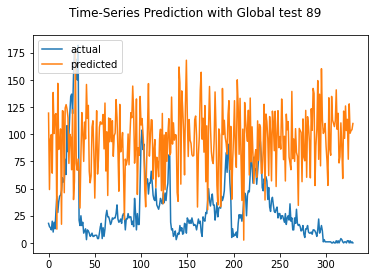

Test MAE: 68.958
Test RMSE: 78.337
Test sMAPE: 115.668
Test R Squared: -5.350
{'mae': 68.95810894930001, 'rmse': 78.33700568305666, 'smape': 115.6681338123228, 'r2': -5.350032326470932}


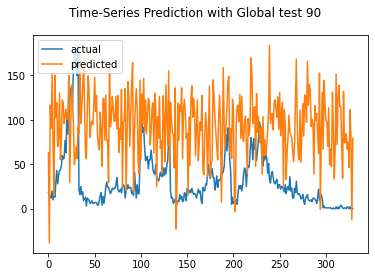

Test MAE: 44.367
Test RMSE: 53.473
Test sMAPE: 101.156
Test R Squared: -1.959
{'mae': 44.36702835595969, 'rmse': 53.47317024505007, 'smape': 101.15622978367156, 'r2': -1.958788125771651}


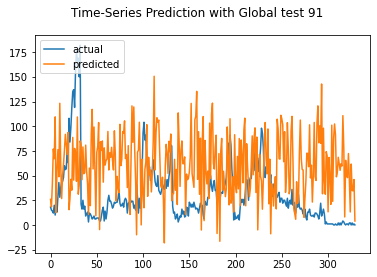

Test MAE: 33.907
Test RMSE: 43.941
Test sMAPE: 99.340
Test R Squared: -0.998
{'mae': 33.906908404014324, 'rmse': 43.94109272740023, 'smape': 99.3400796731276, 'r2': -0.9979458212052916}


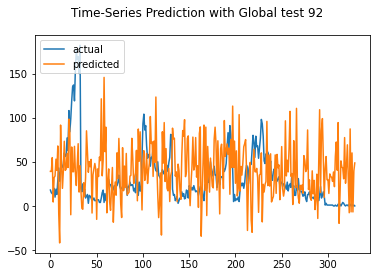

Test MAE: 45.725
Test RMSE: 55.874
Test sMAPE: 105.819
Test R Squared: -2.230
{'mae': 45.72462475119215, 'rmse': 55.87416895793336, 'smape': 105.8186864746614, 'r2': -2.2304584171343986}


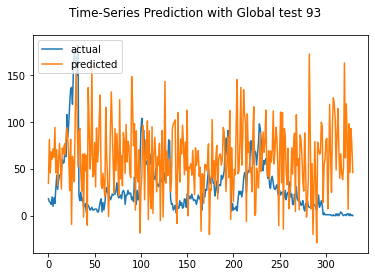

Test MAE: 56.545
Test RMSE: 64.992
Test sMAPE: 108.167
Test R Squared: -3.371
{'mae': 56.54540636801359, 'rmse': 64.99215423256557, 'smape': 108.16671624812139, 'r2': -3.3708295077067403}


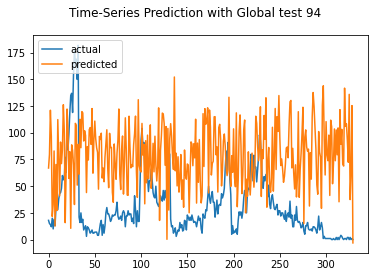

Test MAE: 51.496
Test RMSE: 58.781
Test sMAPE: 108.954
Test R Squared: -2.575
{'mae': 51.49617751023986, 'rmse': 58.78132353914398, 'smape': 108.95445433826059, 'r2': -2.57536778554453}


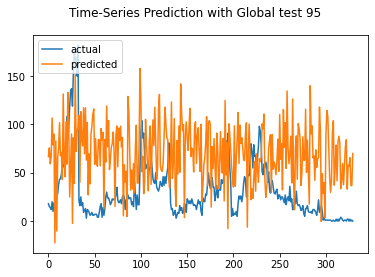

Test MAE: 46.697
Test RMSE: 55.584
Test sMAPE: 102.491
Test R Squared: -2.197
{'mae': 46.69693133758776, 'rmse': 55.5838511807682, 'smape': 102.49053540050917, 'r2': -2.1969752172121035}


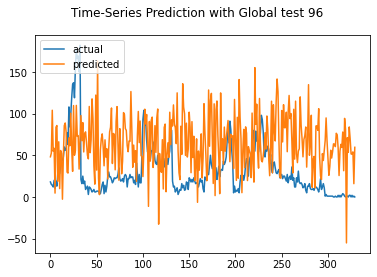

Test MAE: 46.919
Test RMSE: 56.572
Test sMAPE: 104.426
Test R Squared: -2.312
{'mae': 46.91923810866746, 'rmse': 56.57227270634045, 'smape': 104.42617114833394, 'r2': -2.311686777793884}


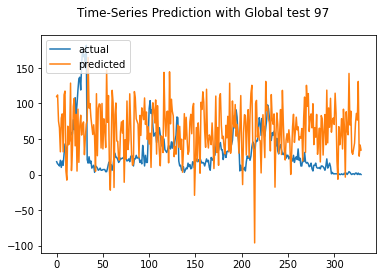

Test MAE: 37.004
Test RMSE: 46.387
Test sMAPE: 103.407
Test R Squared: -1.227
{'mae': 37.0035761475563, 'rmse': 46.38655472800932, 'smape': 103.40666030849732, 'r2': -1.226518132503597}


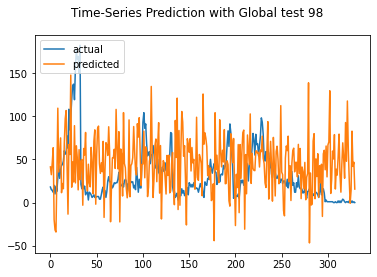

Test MAE: 42.131
Test RMSE: 51.278
Test sMAPE: 102.949
Test R Squared: -1.721
{'mae': 42.13051693981344, 'rmse': 51.278130598421626, 'smape': 102.94904213475081, 'r2': -1.7208610891936584}


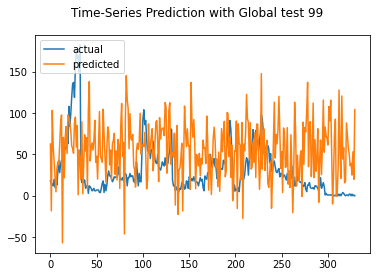

rmse : average=56.632, std=9.281
mae : average=47.377, std=9.561
smape : average=104.852, std=5.965
r2 : average=-2.408, std=1.237


([56.63168370475662, 9.280508215862206],
 [47.37692629650055, 9.56099395247686],
 [104.85170787627113, 5.964646867676422],
 [-2.4077682787683794, 1.2371361000395278])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]


calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')